In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [214]:
chunksize = 10000
data_chunks = []

for chunk in pd.read_csv('C:/Users/allan/src/projects/grupal_project/anomaly_detection/lead/test.csv', chunksize=chunksize):
    data_chunks.append(chunk)

data = pd.concat(data_chunks, ignore_index=True)

data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data.fillna({'meter_reading': data['meter_reading'].mean()}, inplace=True)

data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['hour'] = data['timestamp'].dt.hour

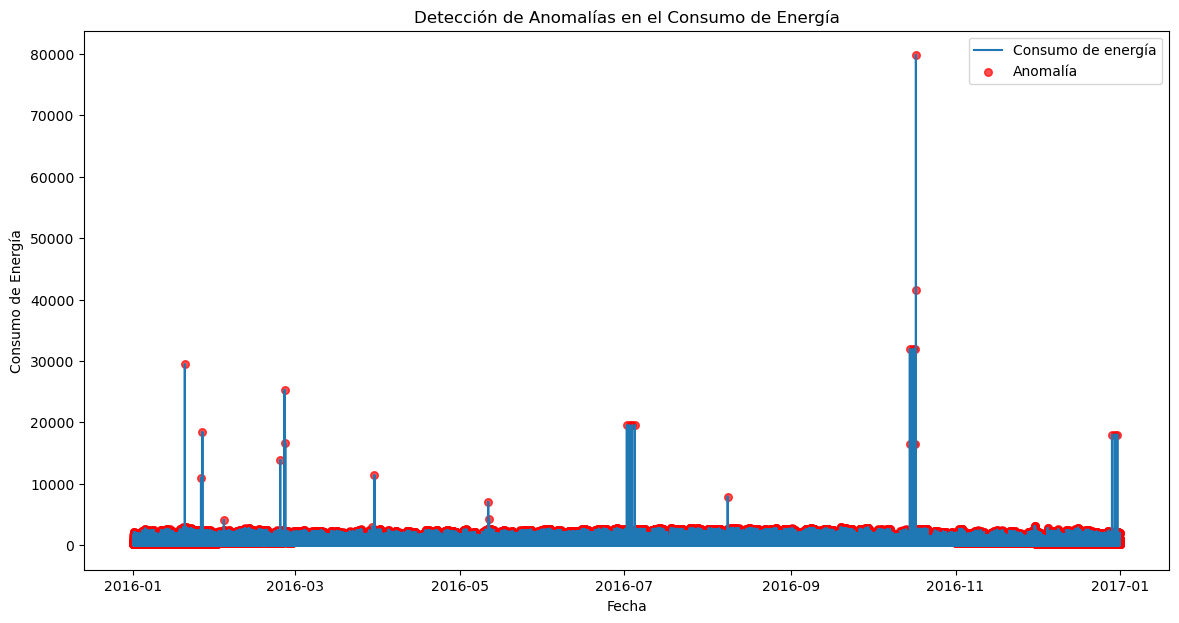

In [215]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['meter_reading', 'month', 'hour']])

iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, max_samples='auto', n_jobs=-1)
data['anomaly'] = (iso_forest.fit_predict(data_scaled) == -1).astype(int)

anomalies = data[data['anomaly'] == 1]

plt.figure(figsize=(14, 7))
plt.plot(data['timestamp'], data['meter_reading'], label='Consumo de energía')
plt.scatter(anomalies['timestamp'], anomalies['meter_reading'], color='red', label='Anomalía', marker='o', s=30, alpha=0.7)
plt.title('Detección de Anomalías en el Consumo de Energía')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.legend()
plt.show()

In [216]:
Q1 = data['meter_reading'].quantile(0.25)
Q3 = data['meter_reading'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

data['true_anomalies'] = ((data['meter_reading'] < lower_limit) | (data['meter_reading'] > upper_limit)).astype(int)

precision = precision_score(data['true_anomalies'], data['anomaly'])
recall = recall_score(data['true_anomalies'], data['anomaly'])
f1 = f1_score(data['true_anomalies'], data['anomaly'])

print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precisión: 0.9440
Recall: 0.3843
F1-Score: 0.5463


In [217]:
X_train, X_test, y_train, y_test = train_test_split(data[['meter_reading', 'month', 'hour']], data['true_anomalies'], test_size=0.2, random_state=42)

iso_forest.fit(X_train)

y_pred = iso_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en los datos de prueba: {accuracy:.4f}")

Precisión en los datos de prueba: 0.0758
